# TODO

# Init

In [1]:
%%capture

%load_ext line_profiler

import importlib
from cycler import cycler
import numpy as np
import time
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.insert(0, 'geo')
sys.path.insert(0, 'bandstructure')

import caustic_frame
importlib.reload(caustic_frame)

import caustic_bandstructure
importlib.reload(caustic_bandstructure)

from delafossite_bandstructure import delafossite

import monte_carlo_simulation as mcs
importlib.reload(mcs)
from shapely.geometry import LineString
from shapely.geometry import Point

import cProfile

# Set default plotting parameters

plt.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33','#348ABD','#988ED5','#777777',
           '#FBC15E','#8EBA42','#FFB5B8'])

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1


plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize']=12

np.seterr(divide='ignore')

# Simulation

## Bar

python multiprocessing
monte carlo git library

### Serial test

In [2]:
k = delafossite()
bar_frame = caustic_frame.Frame('geo/bar.dxf')
fields = np.linspace(10, 15, 8)

start = time.time()
for field in fields:
    np.random.seed(42)
    bar_sim = mcs.Simulation(bar_frame, k, 0, field)
    edge_to_collisions, trajectories = bar_sim.run_simulation(10)
    print(f'{field:.1f} T: {list(map(len, trajectories))}')
print(f'Completed in {time.time() - start:.1f} s')

10.0 T: [12387, 5589, 16896, 31192, 4994, 7317, 4151, 9212, 4536, 10621]
10.7 T: [12759, 23183, 40706, 12485, 26762, 4435, 28784, 23003, 9617, 14041]
11.4 T: [5093, 14136, 5042, 10154, 5377, 5518, 5791, 5539, 15954, 5146]
12.1 T: [5314, 6154, 5193, 7369, 5564, 7469, 6363, 6329, 5043, 7087]
12.9 T: [5801, 6328, 6443, 6032, 5702, 5801, 6127, 7163, 5441, 7135]
13.6 T: [6558, 6201, 6761, 6439, 6431, 7997, 7004, 6587, 8107, 7778]
14.3 T: [7095, 7304, 6890, 6956, 6411, 7054, 7851, 7744, 8224, 6950]
15.0 T: [7335, 7732, 8330, 7573, 8560, 8085, 6808, 8233, 8107, 6546]
Completed in 19.4 s


### Parallel test

In [3]:
start = time.time()
results = []
np.random.seed(42)
with multiprocessing.Pool(maxtasksperchild=1) as p:
    for field in fields:
        bar_sim = mcs.Simulation(bar_frame, k, 0, field)
        results.append(p.apply_async(bar_sim.run_simulation, [10]))
    p.close()
    p.join()
for r, field in zip(results, fields):
    print(f'{field:.1f} T: {list(map(len, r.get()[1]))}')
print(f'Completed in {time.time() - start:.1f} s')

/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:288: RuntimeWarning: divide by zero encountered in true_divide
  (x01*self._frame.y23 - y01*self._frame.x23)
/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:289: RuntimeWarning: divide by zero encountered in true_divide
  us = -(x01*y02 - y01*x02) / (x01*self._frame.y23 - y01*self._frame.x23)
/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:288: RuntimeWarning: divide by zero encountered in true_divide
  (x01*self._frame.y23 - y01*self._frame.x23)
/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:289: RuntimeWarning: divide by zero encountered in true_divide
  us = -(x01*y02 - y01*x02) / (x01*self._frame.y23 - y01*self._frame.x23)


10.0 T: [12387, 5589, 16896, 31192, 4994, 7317, 4151, 9212, 4536, 10621]
10.7 T: [12759, 23183, 40706, 12485, 26762, 4435, 28784, 23003, 9617, 14041]
11.4 T: [5093, 14136, 5042, 10154, 5377, 5518, 5791, 5539, 15954, 5146]
12.1 T: [5314, 6154, 5193, 7369, 5564, 7469, 6363, 6329, 5043, 7087]
12.9 T: [5801, 6328, 6443, 6032, 5702, 5801, 6127, 7163, 5441, 7135]
13.6 T: [6558, 6201, 6761, 6439, 6431, 7997, 7004, 6587, 8107, 7778]
14.3 T: [7095, 7304, 6890, 6956, 6411, 7054, 7851, 7744, 8224, 6950]
15.0 T: [7335, 7732, 8330, 7573, 8560, 8085, 6808, 8233, 8107, 6546]
Completed in 9.2 s


geo/caustic_frame.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


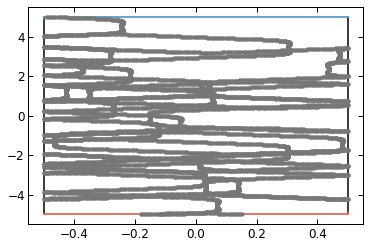

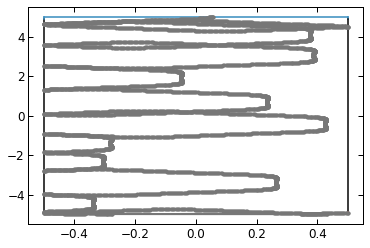

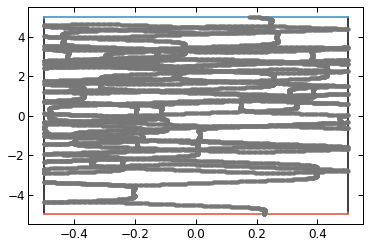

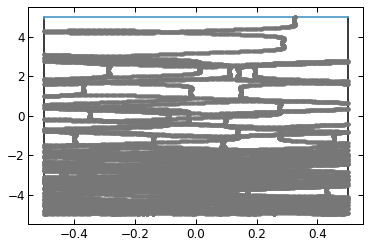

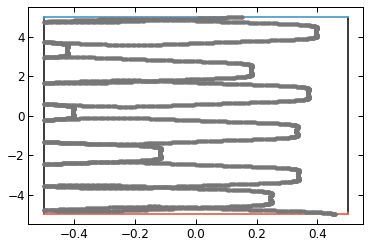

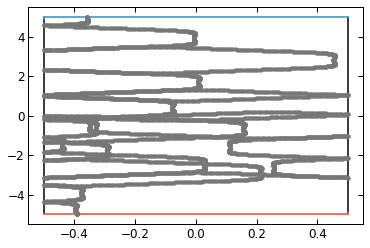

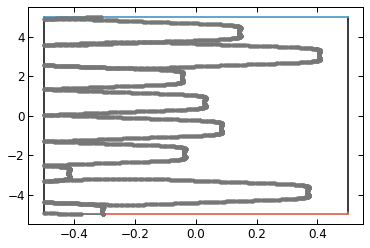

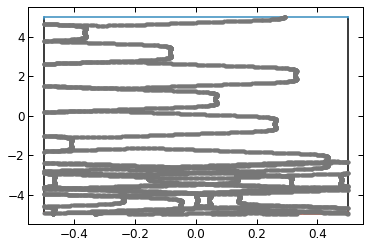

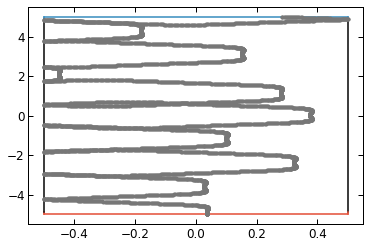

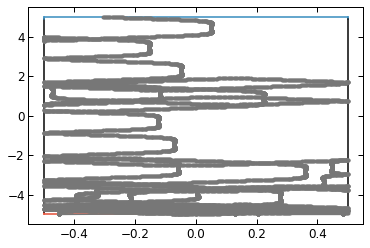

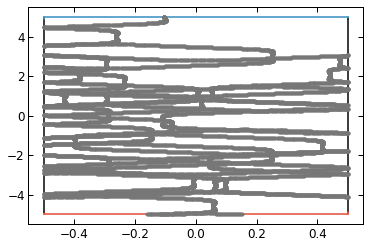

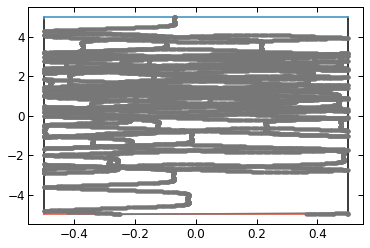

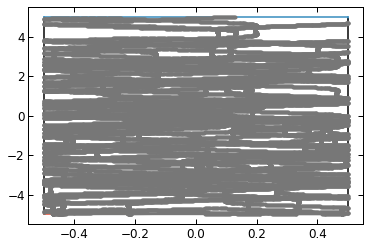

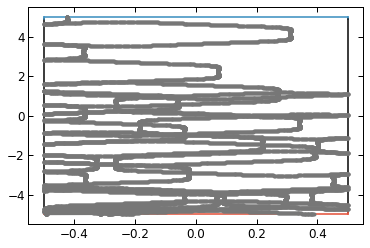

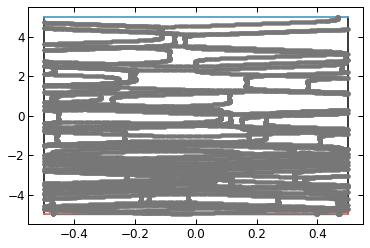

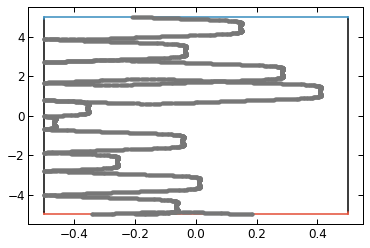

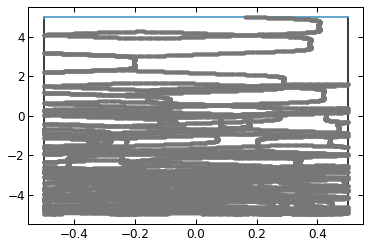

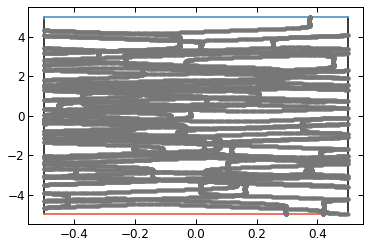

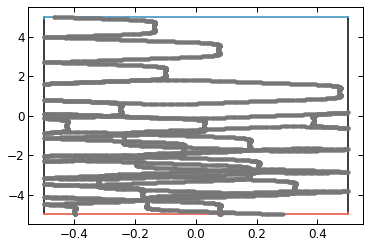

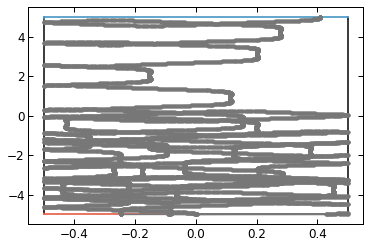

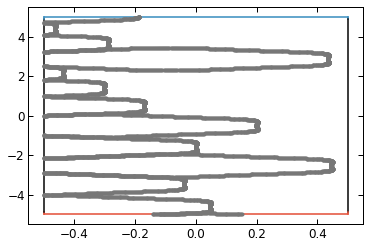

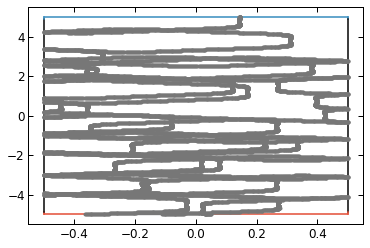

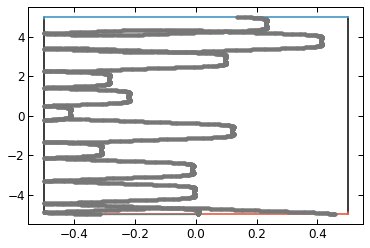

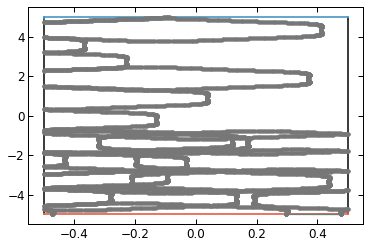

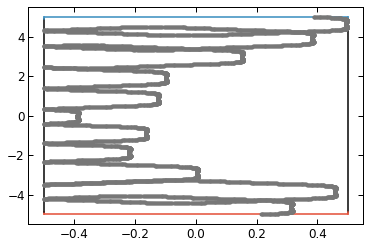

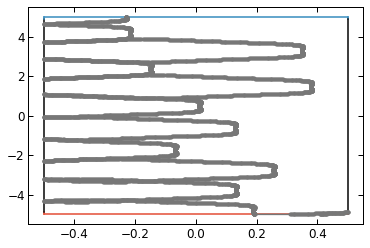

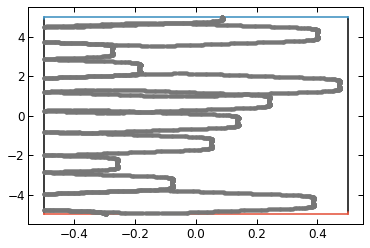

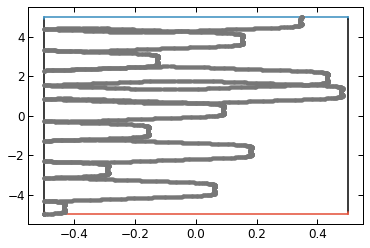

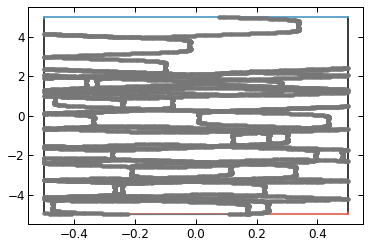

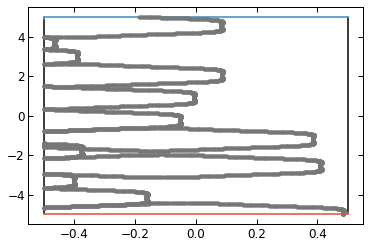

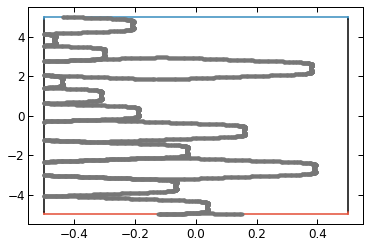

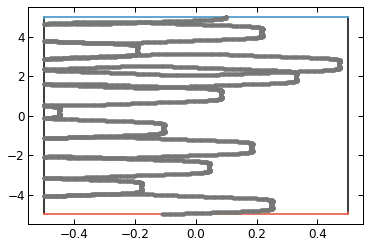

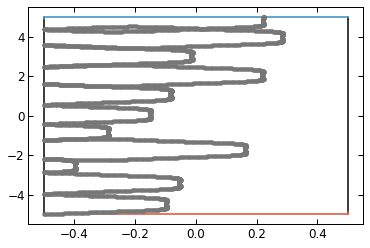

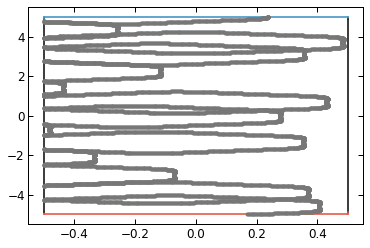

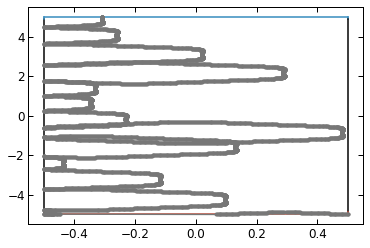

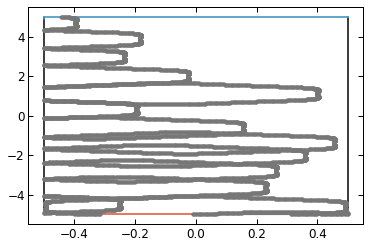

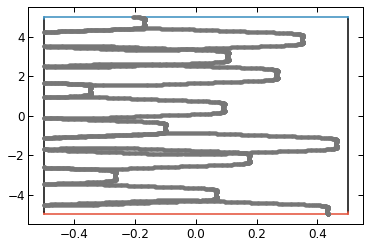

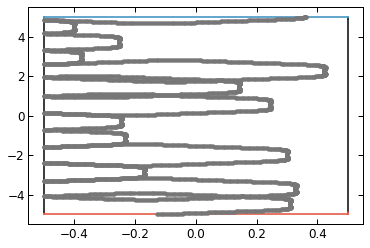

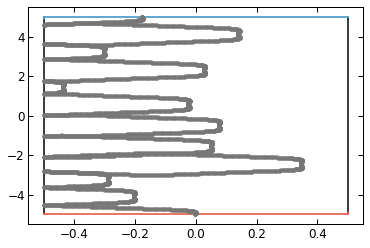

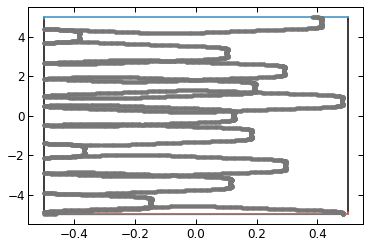

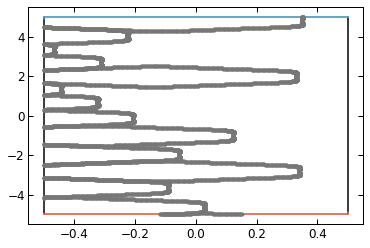

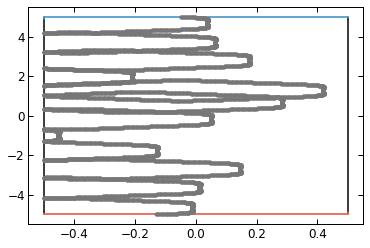

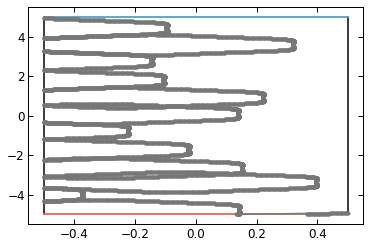

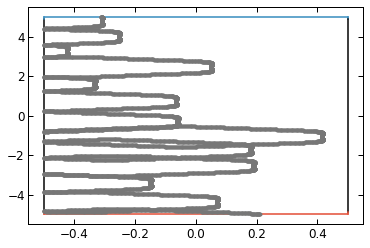

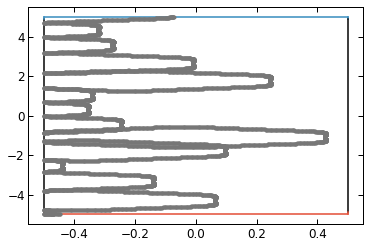

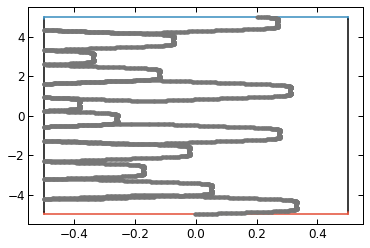

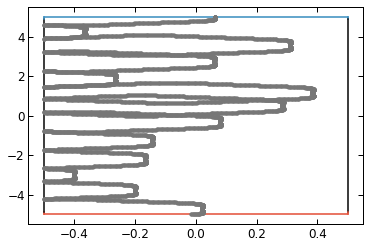

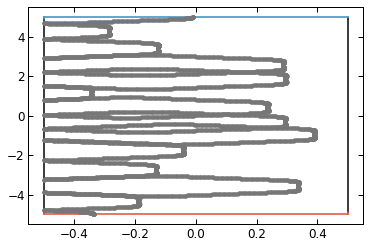

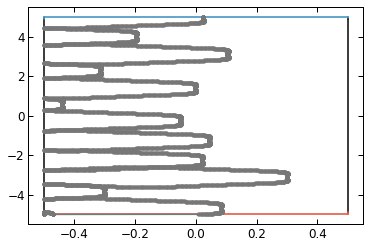

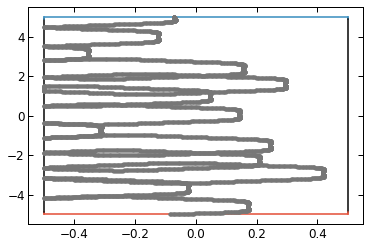

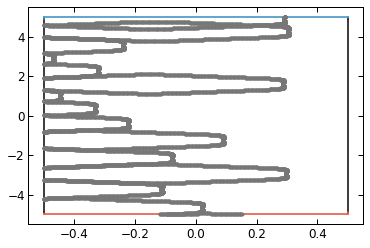

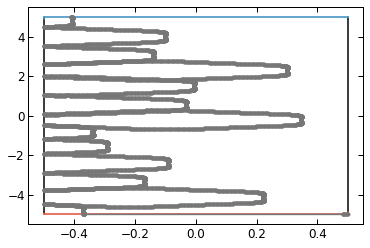

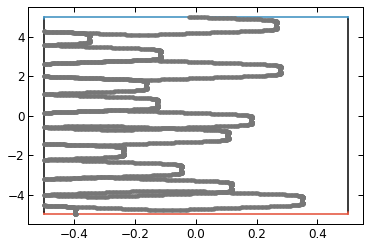

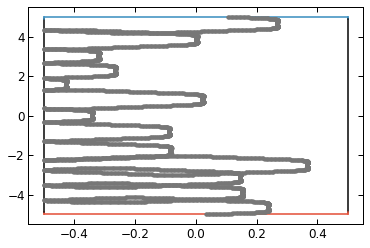

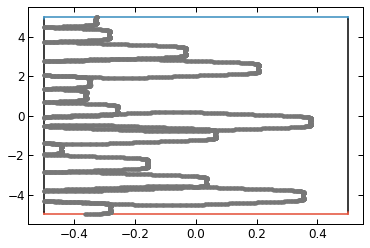

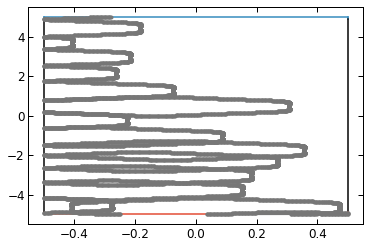

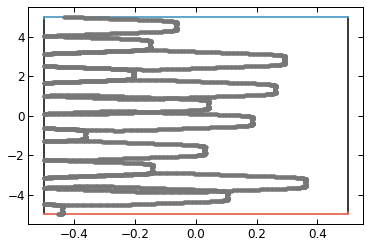

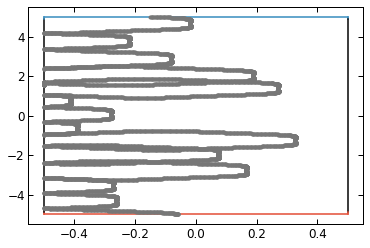

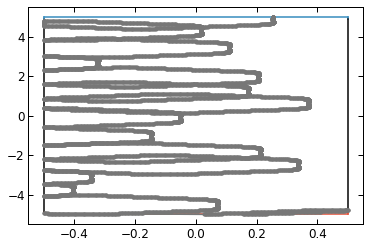

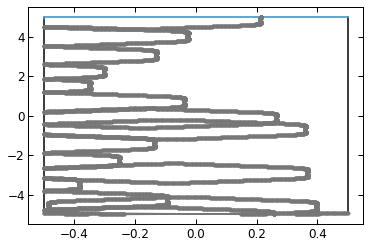

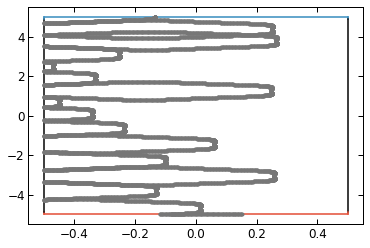

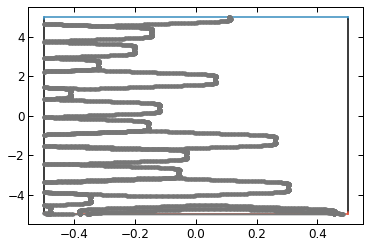

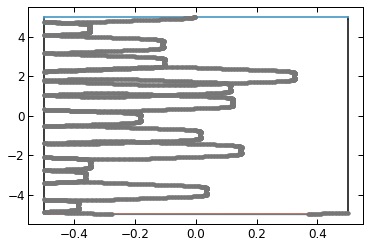

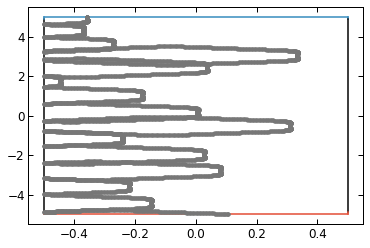

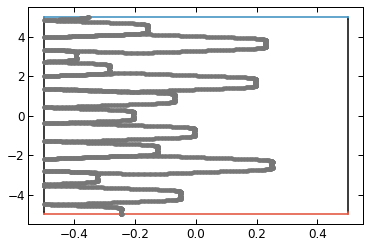

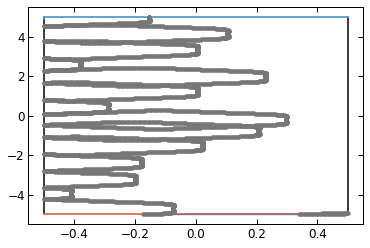

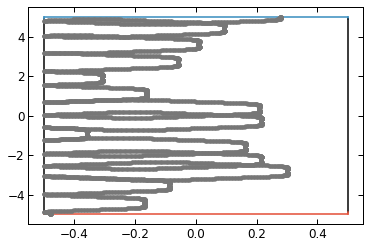

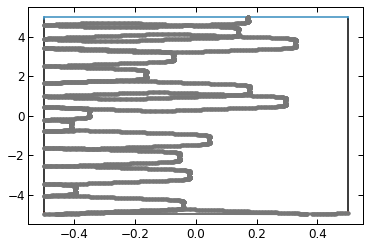

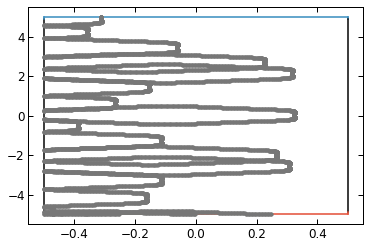

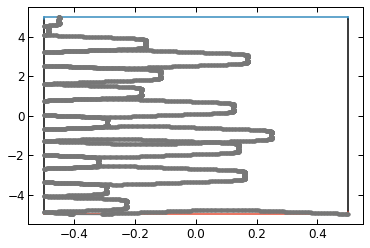

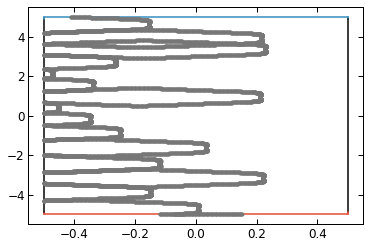

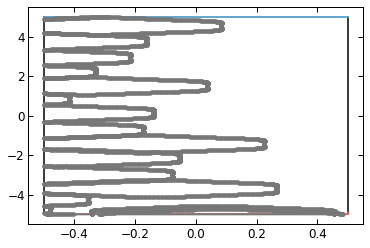

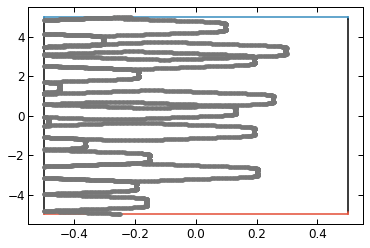

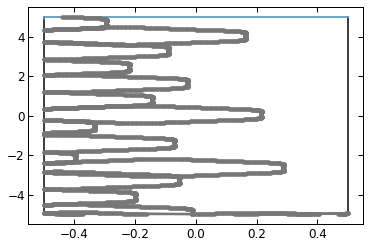

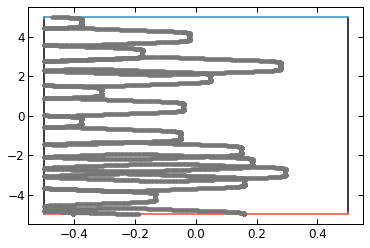

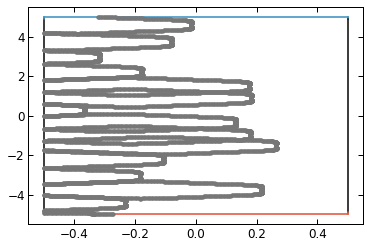

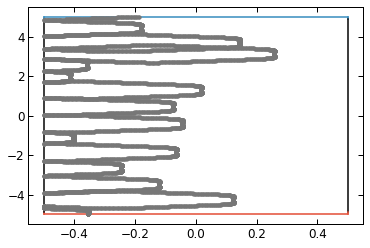

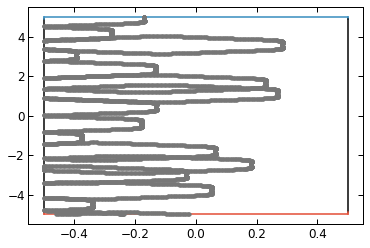

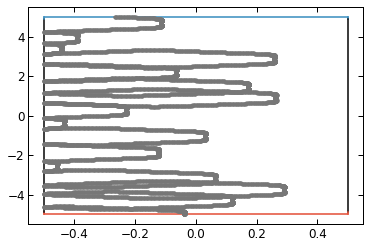

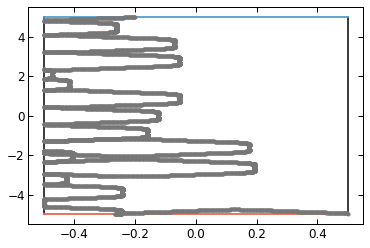

In [4]:
for result in results:
    edge_to_count, trajectories = result.get()
    for trajectory in trajectories:
        fig = bar_frame.gen_fig()
        ns, xs, ys, state, edge = zip(*trajectory)
        plt.plot(xs,ys, 'C3.-')
        #plt.axes().set_aspect('equal')
        #plt.ylim(-5.1,-4)

In [5]:
num_edges = len(bar_frame.edges)
x = 0
y = 0
x_new = 0.5
y_new = 3

x01 = x - x_new
y01 = y - y_new
x02 = x - bar_frame.px0
y02 = y - bar_frame.py0
x_del = x_new - x
y_del = y_new - y

ts = (x02*bar_frame.y23 - y02*bar_frame.x23) / (x01*bar_frame.y23 - y01*bar_frame.x23)
us = -(x01*y02 - y01*x02) / (x01*bar_frame.y23 - y01*bar_frame.x23)

intersections = []
for i, (t, u) in enumerate(zip(ts, us)):
    if 0 <= t and t <= 1 and 0 <= u and u <= 1:
        print(u, t)
        edge = bar_frame.edges[i]
        if x_del * edge.normal[0] + y_del * edge.normal[1] < 0:
            x_int = edge.xs[0] + u*(edge.xs[1] - edge.xs[0])
            y_int = edge.ys[0] + u*(edge.ys[1] - edge.ys[0])
            
            x_t = x + t*(x_new - x)
            y_t = y + t*(y_new- y)
            if x_int != x or y_int != y:
                bias_vector = 1E-10 * \
                    np.array([(x_new-x), (y_new-y)]) / \
                    np.sqrt((x_new-x)**2 + (y_new-y)**2)
                intersections.append(
                    (edge, x_int - bias_vector[0], y_int - bias_vector[1]))
    
print(x_int, y_int)
print(x_t, y_t)

0.19387755102040818 1.0
0.5 3.0
0.5 3.0


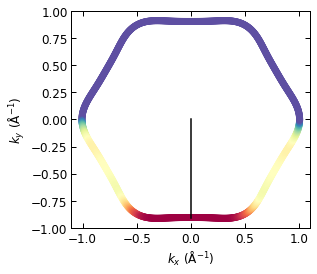

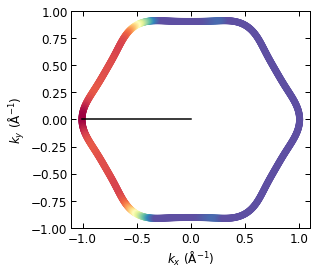

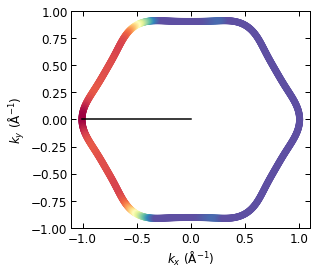

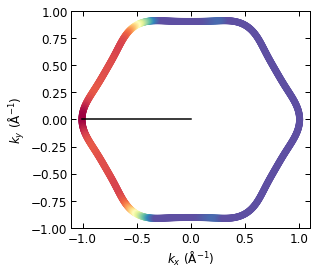

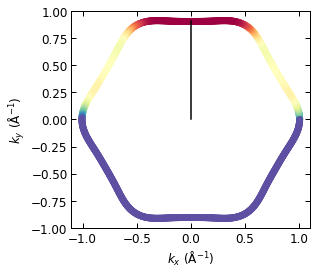

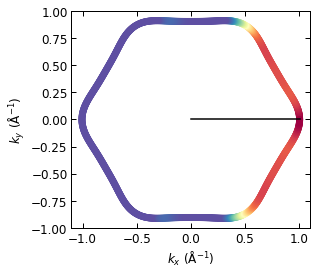

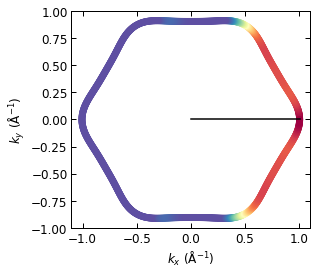

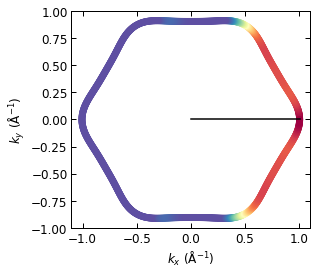

In [6]:
cmap = plt.get_cmap('Spectral_r')

for edge in bar_frame.edges:
    max_p = np.max(edge.in_prob)
    colors = np.array([cmap(p/max_p) for p in edge.in_prob])
    colors = np.append(colors, [colors[0]], axis=0)
    
    fig, ax = plt.subplots()
    plt.plot((0, (np.max(bar_sim._bandstructure.k[0]*np.cos(edge.normal_angle)))*np.cos(edge.normal_angle)), (0, (np.max(bar_sim._bandstructure.k[1]*np.sin(edge.normal_angle)))*np.sin(edge.normal_angle)),'k')
    plt.scatter(bar_sim._bandstructure.k[0], bar_sim._bandstructure.k[1],c=colors)
    plt.xlabel(r'$k_x\ (\mathrm{\AA^{-1}})$')
    plt.ylabel(r'$k_y\ (\mathrm{\AA^{-1}})$')
    ax.set_aspect('equal')

In [7]:
#%lprun -f bar_sim.get_sorted_intersections -f bar_sim.get_intersections -f bar_sim.step_position bar_sim.run_simulation(debug=False)

In [8]:
cProfile.runctx("bar_sim.run_simulation(10, debug=False)", globals(), locals(), sort='cumtime')

         930020 function calls in 3.698 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.698    3.698 {built-in method builtins.exec}
        1    0.014    0.014    3.698    3.698 <string>:1(<module>)
        1    0.177    0.177    3.685    3.685 monte_carlo_simulation.py:39(run_simulation)
    77135    0.344    0.000    3.451    0.000 monte_carlo_simulation.py:74(_step_position)
    77135    0.272    0.000    1.954    0.000 monte_carlo_simulation.py:252(_get_sorted_intersections)
    77135    1.628    0.000    1.629    0.000 monte_carlo_simulation.py:268(_get_intersections)
    77135    0.619    0.000    1.042    0.000 monte_carlo_simulation.py:235(_update_position)
    77135    0.179    0.000    0.423    0.000 <__array_function__ internals>:2(shape)
    77405    0.121    0.000    0.192    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   154444    0.101    0

In [9]:
bar_trajectories = bar_sim.run_simulation(10, debug=True)

## TEF

In [10]:
k = delafossite()
frame = caustic_frame.Frame('geo/tef.dxf')
sim = mcs.Simulation(frame, k, 0, -1, 10)

In [11]:
%lprun -f sim.run_simulation -f sim._get_sorted_intersections -f sim._get_intersections -f sim._step_position -f sim._update_position sim.run_simulation(10, debug=False)

In [12]:
t0 = time.time()
trajectories = sim.run_simulation(10, debug=False)
t1 = time.time()
print(t1-t0)

2.5705602169036865


TypeError: zip argument #1 must support iteration

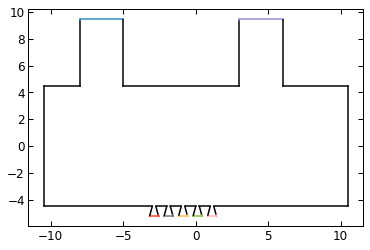

In [13]:
for trajectory in trajectories:
    fig = frame.gen_fig()
    ns, xs, ys = zip(*trajectory)
    plt.plot(xs,ys, 'C3')
    #plt.xlim(-3.5, 1.75)
    #plt.ylim(-5.3, -4)